# Introduction/Abstract

Data set from King County Washington.

# Packages Needed/Setting Global Variables

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline 
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from statsmodels.formula.api import ols
import scipy.stats as stats
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
#from statsmodels.stats.diagnostic import het_breuschpagan
import statsmodels.stats.api as sms




pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

/Users/stevenkyle/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
def Decade(List):
    decade_list=[]
    oldest = List.min()
    i=0
    for x in List:
        i += 1
        while len(decade_list) < i:
            if (x >= oldest) & (x < (oldest+10)):
                decade_list.append('{}-{}'.format(oldest,(oldest+10)))
            oldest += 10
        oldest = List.min()
    return decade_list

In [3]:
def zoningLat(List):
    lowest = List.min()
    highest = List.max()
    distance = highest - lowest
    distance = math.ceil(distance*69)
    zones = []
    for entry in List:
        for zone in list(range(1,distance+1)):
            if ((lowest+(zone-1)/69) <= entry) &(entry < (lowest + zone/69)):
                zones.append(zone)
    return zones

def zoningLong(List):
    lowest = List.min()
    highest = List.max()
    distance = highest-lowest
    distance = math.ceil(distance*54.6)
    zones = []
    for entry in List:
        for zone in list(range(1,distance+1)):
            if ((lowest+(zone-1)/54.6) <= entry) & (entry < (lowest + zone/54.6)):
                zones.append(zone)
    return zones

In [4]:
def FromCenter(Lat,Long):
    Latdiff=[]
    Longdiff=[]
    for LatEntry in Lat:
        Latdiff.append(47.6050-LatEntry)
    for LongEntry in Long:
        Longdiff.append(-122.3344-LongEntry)
    Latdiff = [(x*69)**2 for x in Latdiff]
    Longdiff = [(x*54.6)**2 for x in Longdiff]
    distance = [np.sqrt(a + b) for a, b in zip(Latdiff, Longdiff)]
    return distance

In [5]:
def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.argmax()
            #included.remove(worst_feature)
            del included[worst_feature]
            
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

In [6]:
def ModelCheck(X_train, y_train, X_test, y_test):
    
    X_train_int = sm.add_constant(X_train)
    model = sm.OLS(y_train, X_train_int).fit()
 
    residuals = model.resid
    
    fig, (ax1, ax2) = plt.subplots(nrows=2,ncols=1,figsize=(8,10))
    
    ax1.set_title('Homoscedasticity Check')
    ax1.set_ylabel('Residuals')
    ax1.set_xlabel('Price')
    ax1.axhline(y=0, color='r', linestyle='-')
    ax2.set_title('QQ plot')

    ax1.scatter(x=y_train,y=residuals);
    sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True, ax=ax2);

    fig.show()
    
    names = ['Lagrange multiplier statistic', 'p-value',
            'f-value', 'f p-value']
    bp_test = sms.het_breuschpagan(residuals, model.model.exog)
    print(dict(zip(names,bp_test)))
    
    linreg = LinearRegression()
    linreg.fit(X_train, y_train)

    y_hat_train = linreg.predict(X_train)
    y_hat_test = linreg.predict(X_test)
    train_mse = mean_squared_error(y_train, y_hat_train)
    test_mse = mean_squared_error(y_test, y_hat_test)
    print('Train Mean Squarred Error:', train_mse)
    print('Test Mean Squarred Error:', test_mse)
    print('Train Mean Error:',np.sqrt(train_mse))
    print('Test Mean Error:',np.sqrt(test_mse))
    print('Difference in Mean Error:', np.sqrt(test_mse)-np.sqrt(train_mse))
    
    return model.summary()

In [7]:
def LoggedModelCheck(X_train, y_train, X_test, y_test):
    
    X_train_int = sm.add_constant(X_train)
    model = sm.OLS(y_train, X_train_int).fit()
 
    residuals = model.resid
    
    fig, (ax1, ax2) = plt.subplots(nrows=2,ncols=1,figsize=(8,10))
    
    ax1.set_title('Homoscedasticity Check')
    ax1.set_ylabel('Residuals')
    ax1.set_xlabel('Price')
    ax1.axhline(y=0, color='r', linestyle='-')
    ax2.set_title('QQ plot')

    ax1.scatter(x=y_train,y=residuals);
    sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True, ax=ax2);

    fig.show()
    
    names = ['Lagrange multiplier statistic', 'p-value',
            'f-value', 'f p-value']
    bp_test = sms.het_breuschpagan(residuals, model.model.exog)
    print(dict(zip(names,bp_test)))
    
    linreg = LinearRegression()
    linreg.fit(X_train, y_train)

    y_hat_train = linreg.predict(X_train)
    y_hat_test = linreg.predict(X_test)
    y_hat_train = np.exp(y_hat_train)
    y_hat_test = np.exp(y_hat_test)
    y_train = np.exp(y_train)
    y_test = np.exp(y_test)
    train_mse = mean_squared_error(y_train, y_hat_train)
    test_mse = mean_squared_error(y_test, y_hat_test)
    print('Train Mean Squarred Error:', train_mse)
    print('Test Mean Squarred Error:', test_mse)
    print('Train Mean Error:',np.sqrt(train_mse))
    print('Test Mean Error:',np.sqrt(test_mse))
    print('Difference in Mean Error:', np.sqrt(test_mse)-np.sqrt(train_mse))
    
    return model.summary()

# EDA

## Questions about the Data

## Import and Clean the Data

In [8]:
# Import the dataset
df = pd.read_csv('kc_house_data.csv')

#Dropping id column
df = df.drop(['id'],axis=1)

#Dropping outliers using transformed std deviation of 2.5 (99%)
#Logging price to create a normal distribution and then using that std to drop outliers
df['log_price'] = df['price'].map(lambda x: np.log(x))
maximum_log_price= df.log_price.mean() + (2.5*df.log_price.std())
minimum_log_price = df.log_price.mean() - (2.5*df.log_price.std())
df = df[(df['log_price'] >= minimum_log_price ) & 
            (df['log_price'] <= maximum_log_price)]
df = df.drop(['log_price'],axis=1)

# Creating a new column for the year sold, dropping origianl date
df['year_sold'] = df.date.apply(lambda x: x[-4:]).astype(int)
df = df.drop(['date'], axis=1)

# Changing bedroom number for outlier, I think it was a typo of hitting 3 twice
# based off of the sqft
df.at[15856, 'bedrooms'] = 3

# Replacing NaN values in 'waterfront' with 0
df['waterfront'] = df['waterfront'].fillna(0)

# Replacing NaN values in view with the median/mode value which is 0 (63 entries)
# 0 means house was not viewed
df['view'] = df['view'].fillna(0)

# Replacing ? in sqft_basement and converting to float
df['sqft_basement'] = df['sqft_basement'].replace('?',0).astype(float)

# yr_renovated and renovated columns
df['yr_renovated'] = df['yr_renovated'].fillna(0)
df['Renovated'] = df['yr_renovated'] > 0
df['Renovated'] = df['Renovated'].astype(int)
df['yr_renovated'] = df['yr_renovated'].replace(0,df['yr_built'])

#Adding column for age when sold
df['Age_When_Sold'] = df['year_sold'] - df['yr_built']

#Adding column for years since renovation when sold and dropping yr_renovated
df['Age_Since_Renovation'] = df['year_sold'] - df['yr_renovated']

#Adding interaction variable Renovated*Age since renovation
df['Renovated*Age'] = df['Renovated'] * df['Age_Since_Renovation']

#Adding zones for Lat and Long
df['Lat_Zones'] = zoningLat(df['lat'])
df['Long_Zones'] = zoningLong(df['long'])
df['Lat_Zones'] = df['Lat_Zones'].astype(str)
df['Long_Zones'] = df['Long_Zones'].astype(str)
df['DistanceFromCenterOfSeattle'] = FromCenter(df['lat'],df['long'])
#df['Zones'] = df['Lat_Zones'] + 'x' + df['Long_Zones']
df = df.drop(['lat','long','Long_Zones','Lat_Zones'],axis=1)

#Grouping year built by decade
df['yr_built'] = Decade(df.yr_built)

#Dropping 'year_sold',only seems to have two years, not valuable category
df = df.drop(['year_sold'], axis=1)

## Linearity and preprocessing

In [9]:
df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,sqft_living15,sqft_lot15,Renovated,Age_When_Sold,Age_Since_Renovation,Renovated*Age,DistanceFromCenterOfSeattle
0,221900.0,3,1.00,1180,5650,1.0,0.0,0.0,3,7,1180,0.0,1950-1960,1955.0,98178,1340,5650,0,59,59.0,0.0,7.729734
1,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,3,7,2170,400.0,1950-1960,1991.0,98125,1690,7639,1,63,23.0,23.0,8.048045
2,180000.0,2,1.00,770,10000,1.0,0.0,0.0,3,6,770,0.0,1930-1940,1933.0,98028,2720,8062,0,82,82.0,0.0,10.711811
3,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,5,7,1050,910.0,1960-1970,1965.0,98136,1360,5000,0,49,49.0,0.0,6.632568
4,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,3,8,1680,0.0,1980-1990,1987.0,98074,1800,7503,0,28,28.0,0.0,15.822203


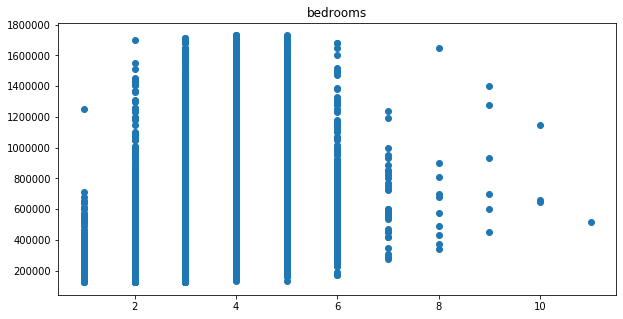

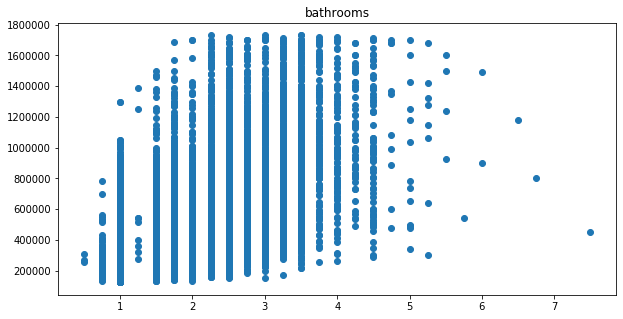

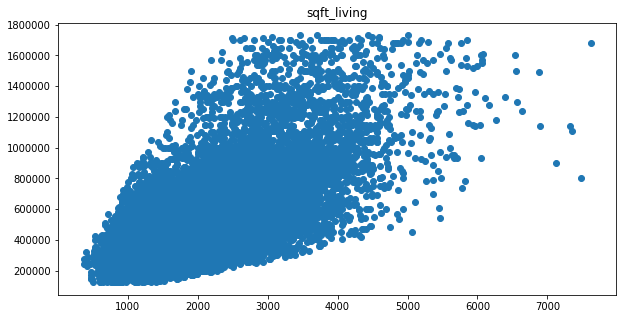

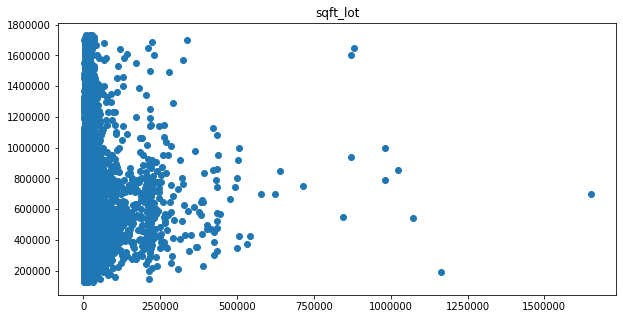

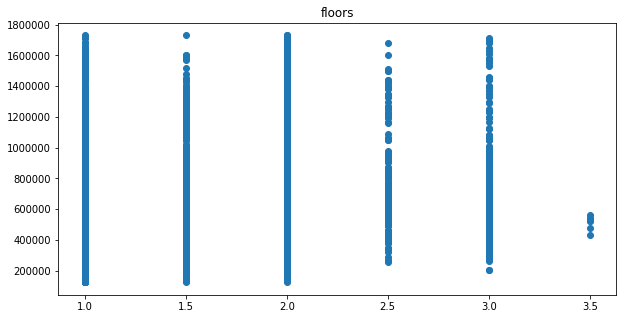

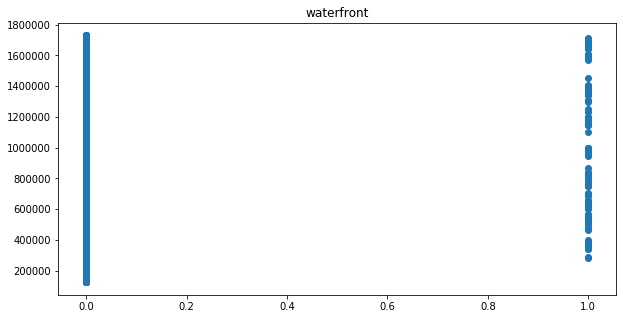

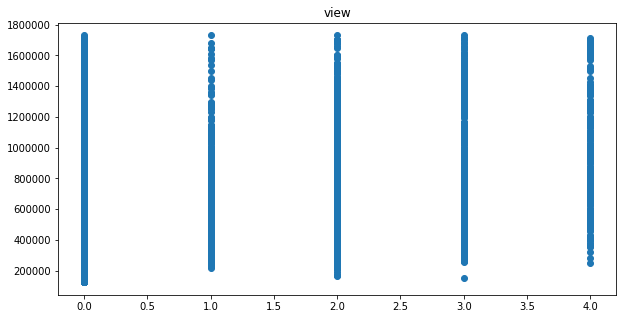

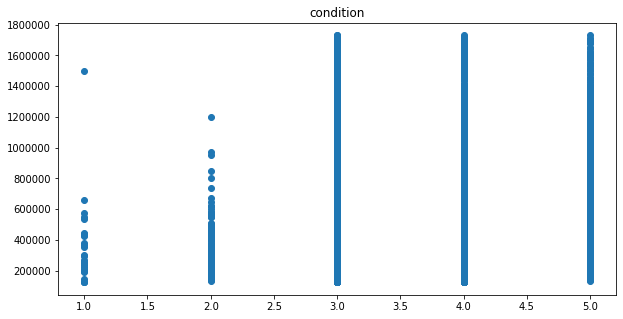

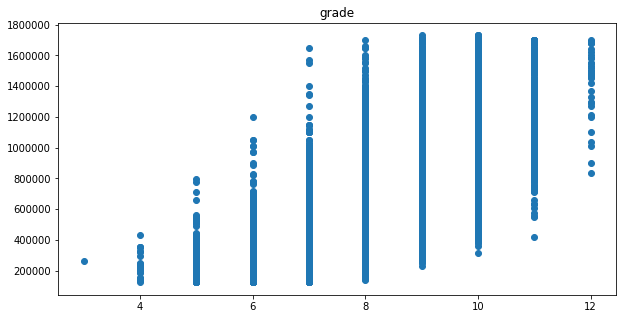

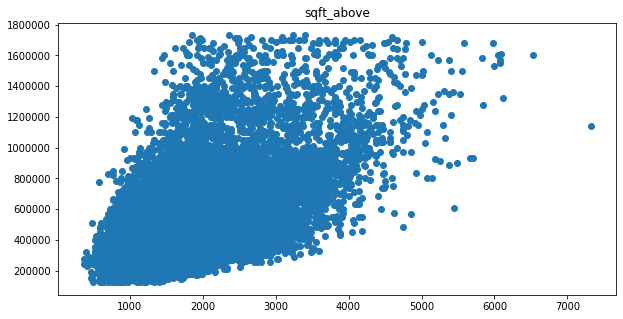

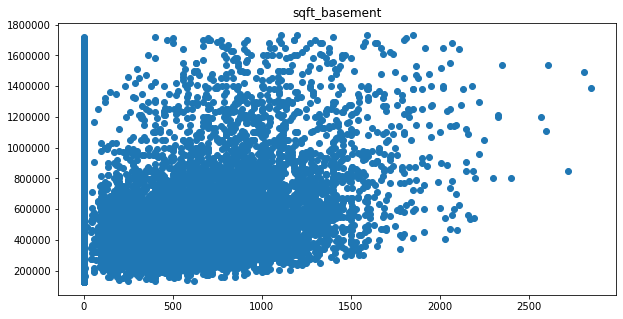

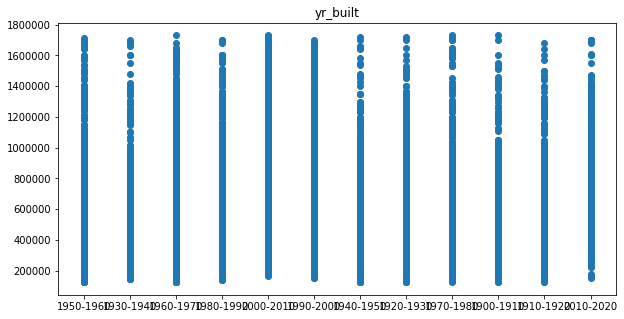

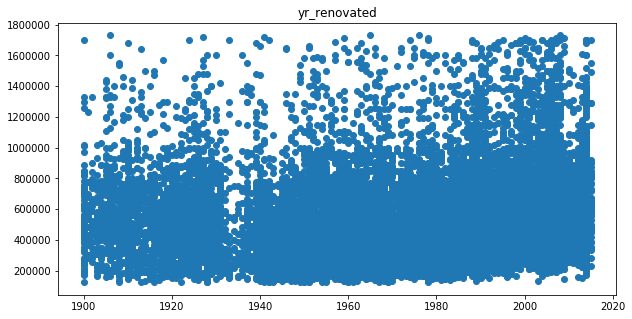

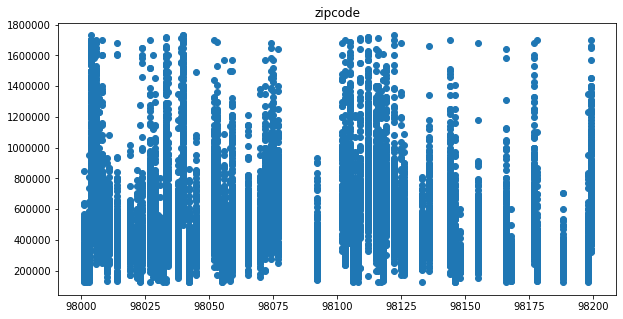

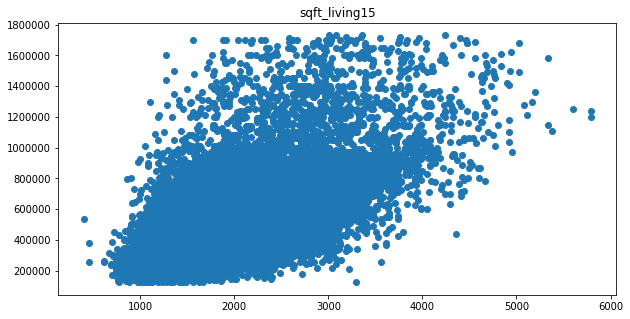

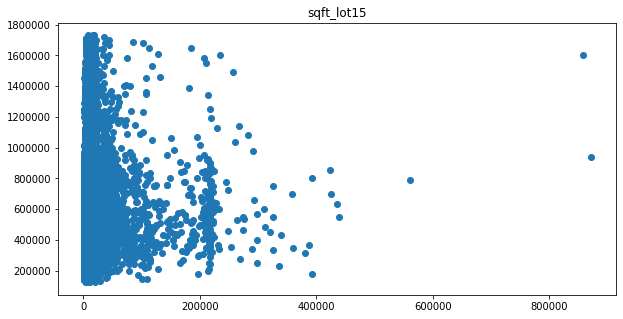

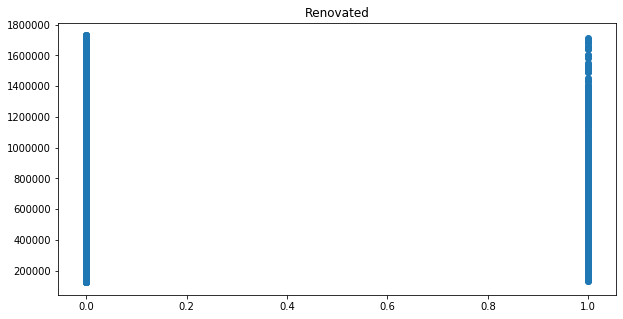

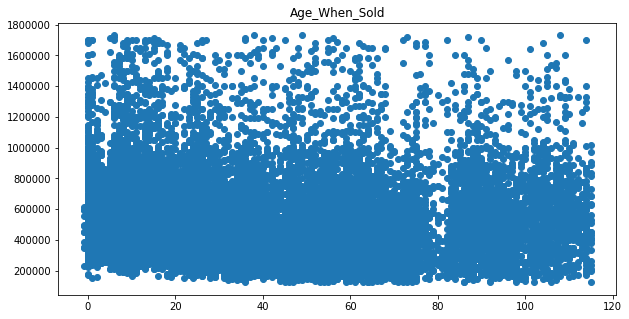

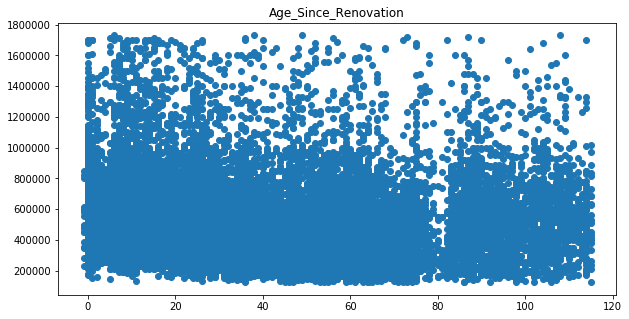

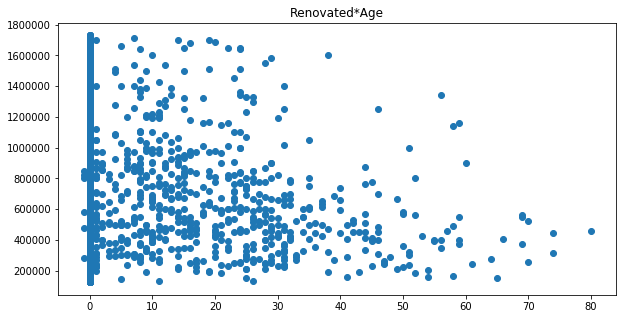

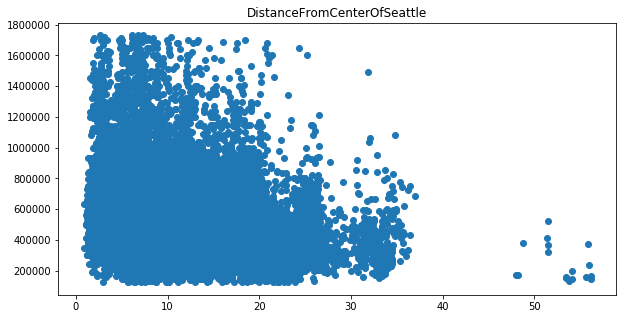

In [10]:
col = list(df.columns)
col.remove('price')
for column in col:
    plt.figure(figsize=(10,5))
    plt.scatter(x=df[column],y=df['price'])
    plt.title(column)
    plt.show()

In [11]:
df.groupby('floors').price.mean()

floors
1.0    434340.500332
1.5    543319.299417
2.0    600064.141948
2.5    784703.394161
3.0    558983.574751
3.5    511916.666667
Name: price, dtype: float64

In [12]:
df.groupby('bedrooms').price.mean()

bedrooms
1     331053.967568
2     404435.375415
3     456816.638880
4     597044.943172
5     678507.925877
6     673851.580392
7     658906.781250
8     694600.000000
9     893999.833333
10    820000.000000
11    520000.000000
Name: price, dtype: float64

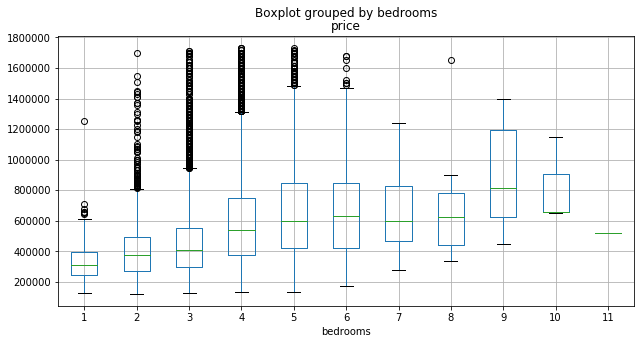

In [13]:
df.boxplot(column='price',by='bedrooms',figsize=(10,5));

In [14]:
df[df['bedrooms']>9]

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,sqft_living15,sqft_lot15,Renovated,Age_When_Sold,Age_Since_Renovation,Renovated*Age,DistanceFromCenterOfSeattle
8748,520000.0,11,3.00,3000,4960,2.0,0.0,0.0,3,7,2400,600.0,1910-1920,1999.0,98106,1420,4960,1,96,15.0,15.0,3.724195
13301,1150000.0,10,5.25,4590,10920,1.0,0.0,2.0,3,9,2500,2090.0,2000-2010,2008.0,98004,2730,10400,0,6,6.0,0.0,12.158580
15147,650000.0,10,2.00,3610,11914,2.0,0.0,0.0,4,7,3010,600.0,1950-1960,1958.0,98006,2040,11914,0,56,56.0,0.0,9.022925
19239,660000.0,10,3.00,2920,3745,2.0,0.0,0.0,4,7,1860,1060.0,1910-1920,1913.0,98105,1810,3745,0,101,101.0,0.0,4.112360


In [15]:
df.groupby('yr_built').price.mean()

yr_built
1900-1910    590486.476038
1910-1920    550961.313776
1920-1930    567119.279966
1930-1940    542317.136634
1940-1950    436813.529686
1950-1960    464458.543722
1960-1970    442818.585301
1970-1980    482108.517897
1980-1990    506697.418109
1990-2000    548268.407205
2000-2010    565220.889245
2010-2020    590593.296603
Name: price, dtype: float64

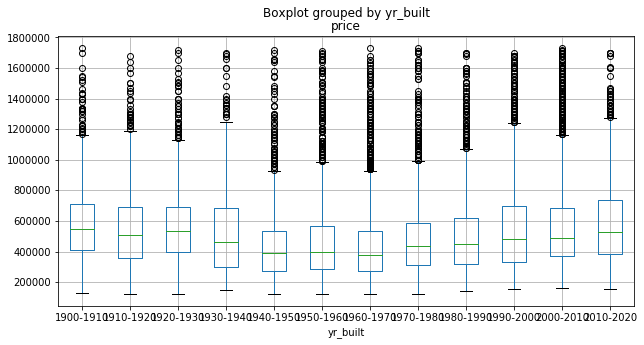

In [16]:
df.boxplot(column='price',by='yr_built',figsize=(10,5));

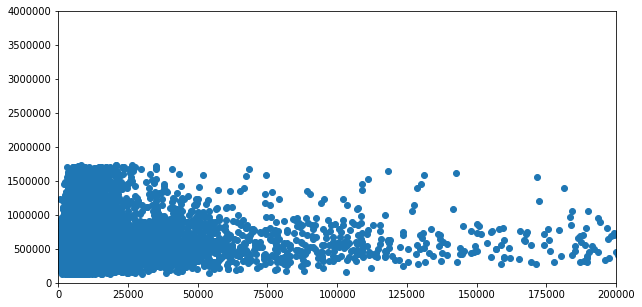

In [17]:
plt.figure(figsize=(10,5))
plt.xlim((-.05,200000))
plt.ylim((-.05,4000000))
plt.scatter(x=df['sqft_lot'],y=df['price'])
plt.show()

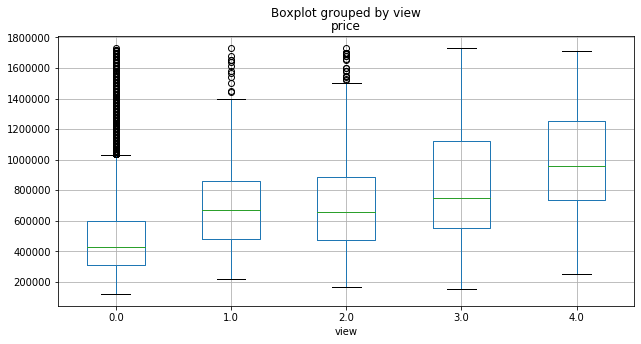

In [18]:
df.boxplot(column='price',by='view',figsize=(10,5));

In [19]:
df.groupby('view').price.mean()

view
0.0    485979.942913
1.0    714300.574194
2.0    717012.633588
3.0    836975.826087
4.0    998578.722944
Name: price, dtype: float64

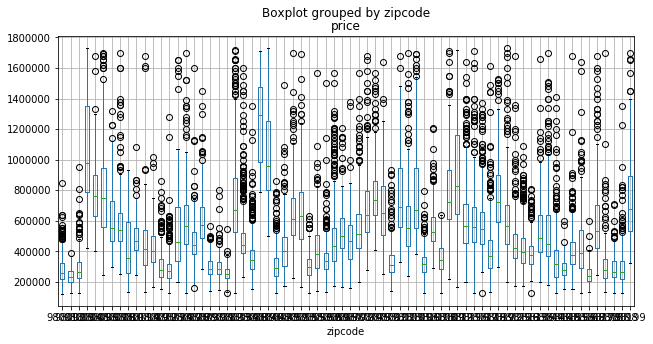

In [20]:
df.boxplot(column='price',by='zipcode',figsize=(10,5));

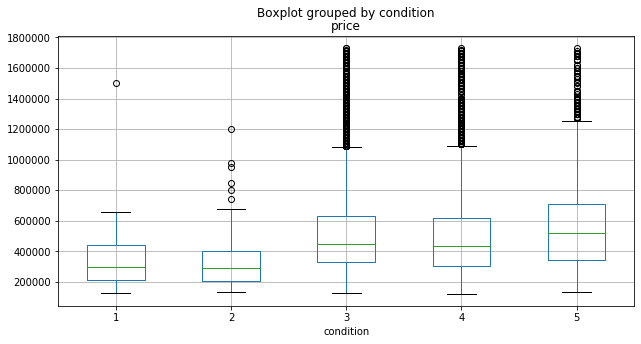

In [21]:
df.boxplot(column='price',by='condition',figsize=(10,5));

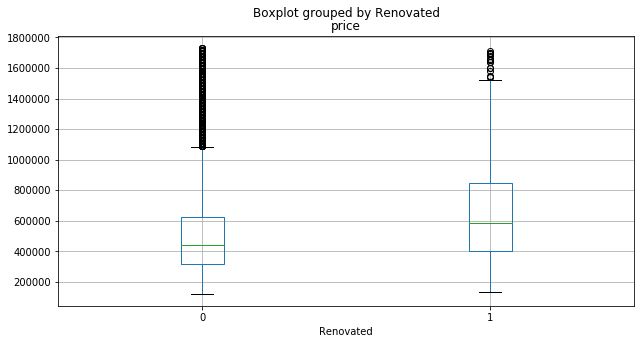

In [22]:
df.boxplot(column='price',by='Renovated',figsize=(10,5));

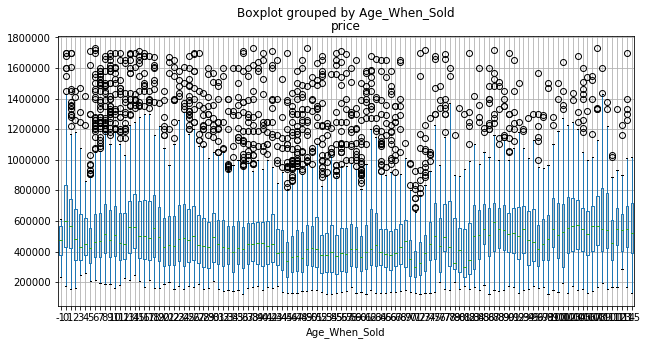

In [23]:
df.boxplot(column='price',by='Age_When_Sold',figsize=(10,5));

Looking at linearity. It looks like the features that could have strong linear relationships are:
1. bathrooms
2. sqft_living
3. sqft_above
4. sqft_living15
5. grade

Ones that seem like they could have a mild linear relationship are:

1. bedrooms
2. grade
3. sqft_basement
4. condition
5. Floors

The variable grade seems like it's actually exponential, might be worth exploring later.

In [24]:
# These are the variables that are going to be dropped
# for not meeting the linearity assumption, some categoricals are going to stay
# for example zipcode

non_linearity = ['sqft_lot','yr_built','yr_renovated','sqft_lot15',
                 'Age_When_Sold','Age_Since_Renovation','Renovated*Age','zipcode']

df_linear = df.drop(non_linearity,axis=1)

In [25]:
#Creating Dummie Variables double check this list
#Taking out bedrooms, bathrooms, view, condition
dummy_list = ['Renovated','waterfront'] #Trying grade as a continuous variable, Also try without zipcode
dum=df_linear[dummy_list].astype('category')
dummies = pd.get_dummies(dum[dummy_list],prefix=dummy_list,drop_first=True)
df_preprocessed = df_linear.drop(dummy_list, axis=1)
df_preprocessed = pd.concat([df_preprocessed,dummies],axis=1)

## Notes

In [26]:
df_preprocessed.head()

,price,bedrooms,bathrooms,sqft_living,floors,view,condition,grade,sqft_above,sqft_basement,sqft_living15,DistanceFromCenterOfSeattle,Renovated_1,waterfront_1.0
0,221900.0,3,1.00,1180,1.0,0.0,3,7,1180,0.0,1340,7.729734,0,0
1,538000.0,3,2.25,2570,2.0,0.0,3,7,2170,400.0,1690,8.048045,1,0
2,180000.0,2,1.00,770,1.0,0.0,3,6,770,0.0,2720,10.711811,0,0
3,604000.0,4,3.00,1960,1.0,0.0,5,7,1050,910.0,1360,6.632568,0,0
4,510000.0,3,2.00,1680,1.0,0.0,3,8,1680,0.0,1800,15.822203,0,0


# Modeling

## First Model

In [27]:
#Omitting zones for now, too much data to process
y = df_preprocessed['price']
X = df_preprocessed.drop(['price'],axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

{'Lagrange multiplier statistic': 1170.4443244784218, 'p-value': 4.040013148905341e-242, 'f-value': 96.63297765875885, 'f p-value': 4.1755752223251755e-251}
Train Mean Squarred Error: 22287819244.838852
Test Mean Squarred Error: 21298110485.863026
Train Mean Error: 149291.05547499773
Test Mean Error: 145938.72168092683
Difference in Mean Error: -3352.3337940709025


/Users/stevenkyle/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.690
Model:                            OLS   Adj. R-squared:                  0.690
Method:                 Least Squares   F-statistic:                     2903.
Date:                Sat, 31 Oct 2020   Prob (F-statistic):               0.00
Time:                        17:27:38   Log-Likelihood:            -2.2597e+05
No. Observations:               16949   AIC:                         4.520e+05
Df Residuals:                   16935   BIC:                         4.521e+05
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                       -3.509e+05   1.36e+04    -25.873      0.000   -3.77e+05   -3.24e+05
bedrooms                    -1.823e+04   1668.672    -10.923      0.000   -2.15e+04    -1.5e+04
bathrooms                    6174.4500   2608.602      2.367      0.018    1061.318    1.13e+04
sqft_living                    64.2675     15.651      4.106      0.000      33.591      94.944
floors                      -1.177e+04   2982.287     -3.946      0.000   -1.76e+04   -5923.479
view                         3.833e+04   1795.492     21.345      0.000    3.48e+04    4.18e+04
condition                    4.474e+04   1863.069     24.012      0.000    4.11e+04    4.84e+04
grade                        7.055e+04   1787.054     39.480      0.000    6.71e+04    7.41e+04
sqft_above                     65.5090     15.647      4.187      0.000      34.839      96.179
sqft_basement                  28.7063     15.504      1.852      0.064      -1.683      59.096
sqft_living15                  73.4585      2.932     25.054      0.000      67.712      79.205
DistanceFromCenterOfSeattle -1.386e+04    176.132    -78.676      0.000   -1.42e+04   -1.35e+04
Renovated_1                  8.802e+04   6436.431     13.676      0.000    7.54e+04    1.01e+05
waterfront_1.0               2.718e+05   1.94e+04     14.042      0.000    2.34e+05     3.1e+05
==============================================================================
Omnibus:                     3095.360   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             8917.910
Skew:                           0.966   Prob(JB):                         0.00
Kurtosis:                       5.983   Cond. No.                     6.02e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.02e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

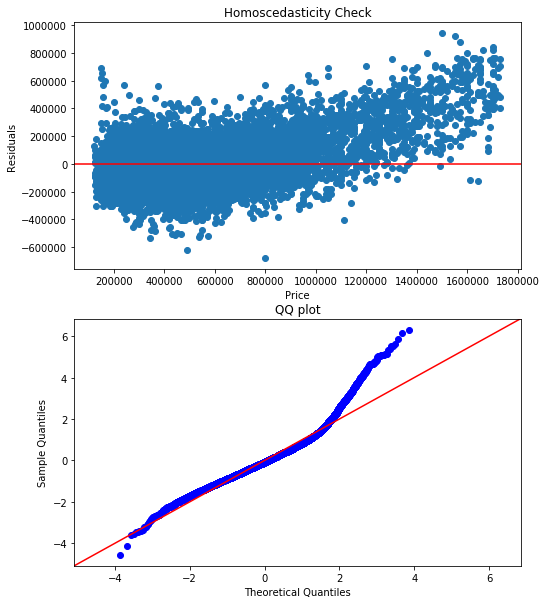

In [28]:
ModelCheck(X_train, y_train, X_test, y_test)

## Looking at Multicollinearity

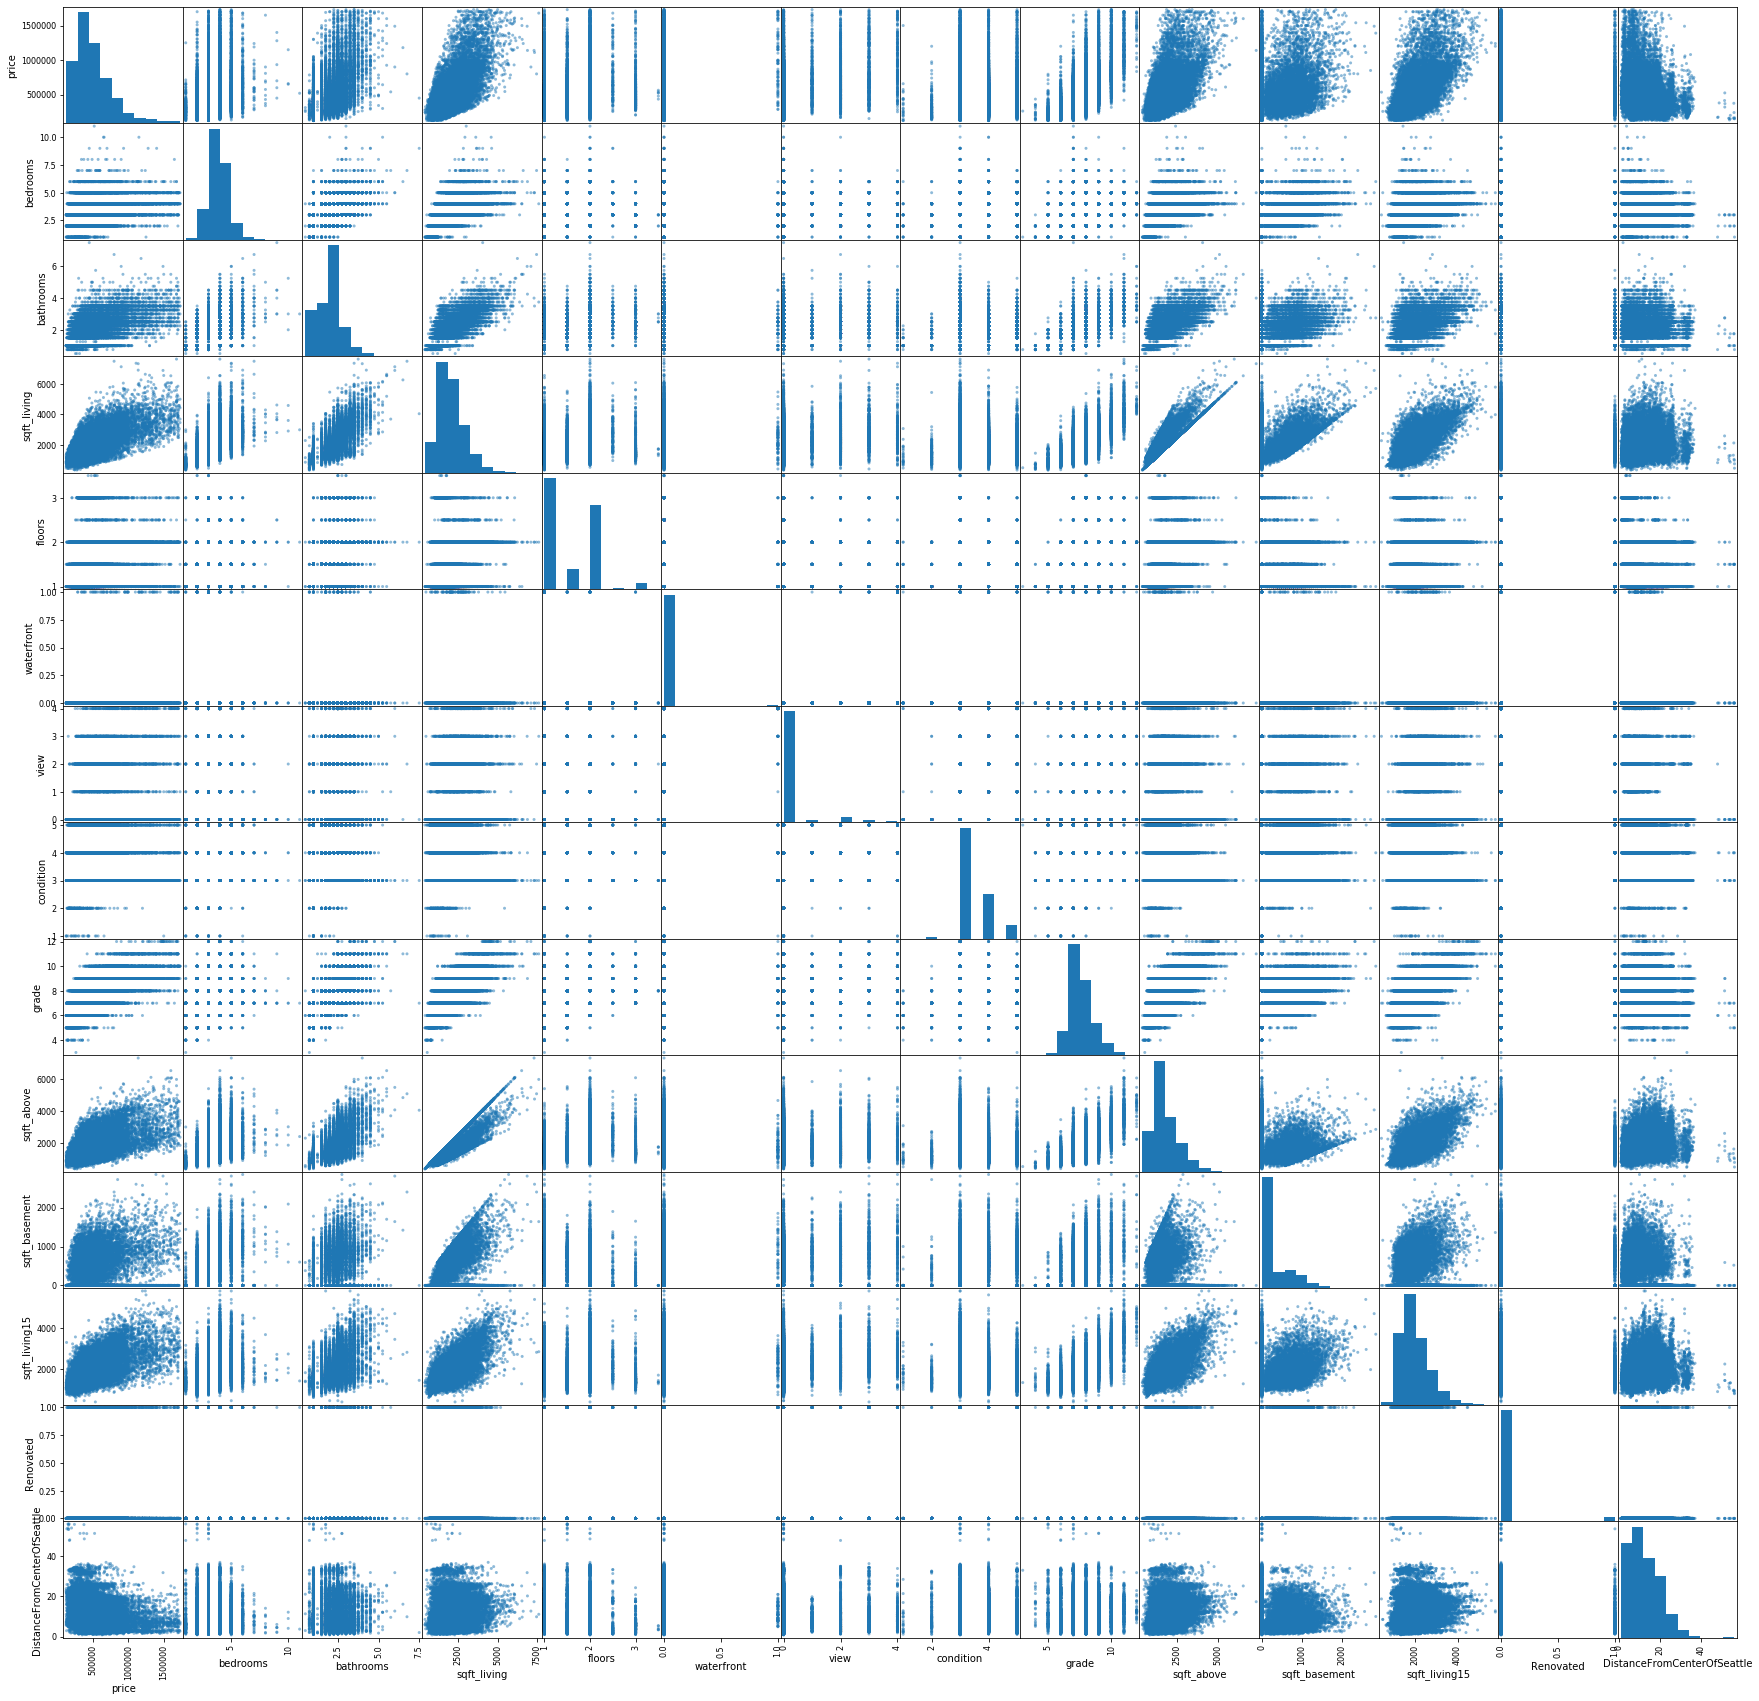

In [29]:
pd.plotting.scatter_matrix(df_linear,figsize  = [30, 30]);
plt.show()

In [30]:
test_corr=df_linear.corr().abs().stack().reset_index().sort_values(0, ascending=False)
test_corr['pairs'] = list(zip(test_corr.level_0, test_corr.level_1))
test_corr.set_index(['pairs'],inplace=True)
test_corr.drop(['level_0','level_1'],axis=1,inplace=True)
test_corr.columns = ['cc']
test_corr.drop_duplicates(inplace=True)
test_corr[(test_corr.cc >.75) & (test_corr.cc<1)]

,cc
pairs,
"(sqft_above, sqft_living)",0.863839
"(sqft_living, sqft_living15)",0.752585


It looks like sqft_living is highly correlated with a bunch of variables. Let's take out sqft_above and sqft_living15 to see if this will fix the correlation.

In [31]:
df_linear = df_linear.drop(['sqft_living15','sqft_above'],axis=1)

In [32]:
test_corr2=df_linear.corr().abs().stack().reset_index().sort_values(0, ascending=False)
test_corr2['pairs'] = list(zip(test_corr2.level_0, test_corr2.level_1))
test_corr2.set_index(['pairs'],inplace=True)
test_corr2.drop(['level_0','level_1'],axis=1,inplace=True)
test_corr2.columns = ['cc']
test_corr2.drop_duplicates(inplace=True)
test_corr2[(test_corr2.cc >.75) & (test_corr2.cc<1)]

,cc
pairs,


Sqft_above and grade also seems to be correlated but I believe they are very different and just happen to be correlated so I'm going to keep those variables.

In [33]:
#dropping sqft_living15,sqft_above from actual test/train set
X_train = X_train.drop(['sqft_living15','sqft_above'],axis=1)
X_test = X_test.drop(['sqft_living15','sqft_above'],axis=1)

## Second Model after removing collinearity

{'Lagrange multiplier statistic': 1177.8633300303447, 'p-value': 9.549671657383151e-246, 'f-value': 114.99413965807548, 'f p-value': 6.997099177206606e-255}
Train Mean Squarred Error: 23153892503.217632
Test Mean Squarred Error: 21778317613.982586
Train Mean Error: 152164.03156862542
Test Mean Error: 147574.78651172965
Difference in Mean Error: -4589.245056895772


/Users/stevenkyle/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.678
Model:                            OLS   Adj. R-squared:                  0.678
Method:                 Least Squares   F-statistic:                     3246.
Date:                Sat, 31 Oct 2020   Prob (F-statistic):               0.00
Time:                        17:28:39   Log-Likelihood:            -2.2630e+05
No. Observations:               16949   AIC:                         4.526e+05
Df Residuals:                   16937   BIC:                         4.527e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                       -3.577e+05   1.38e+04    -25.897      0.000   -3.85e+05   -3.31e+05
bedrooms                    -1.992e+04   1699.347    -11.722      0.000   -2.33e+04   -1.66e+04
bathrooms                    3862.7480   2654.068      1.455      0.146   -1339.501    9064.997
sqft_living                   164.9122      2.923     56.421      0.000     159.183     170.641
floors                      -2.098e+04   2988.641     -7.020      0.000   -2.68e+04   -1.51e+04
view                         4.351e+04   1814.343     23.979      0.000       4e+04    4.71e+04
condition                    4.299e+04   1897.087     22.663      0.000    3.93e+04    4.67e+04
grade                        8.434e+04   1736.809     48.559      0.000    8.09e+04    8.77e+04
sqft_basement                 -49.9698      3.767    -13.266      0.000     -57.353     -42.587
DistanceFromCenterOfSeattle -1.328e+04    177.801    -74.698      0.000   -1.36e+04   -1.29e+04
Renovated_1                  7.976e+04   6550.693     12.175      0.000    6.69e+04    9.26e+04
waterfront_1.0               2.651e+05   1.97e+04     13.441      0.000    2.26e+05    3.04e+05
==============================================================================
Omnibus:                     3016.756   Durbin-Watson:                   1.992
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             8934.888
Skew:                           0.934   Prob(JB):                         0.00
Kurtosis:                       6.027   Cond. No.                     3.77e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.77e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

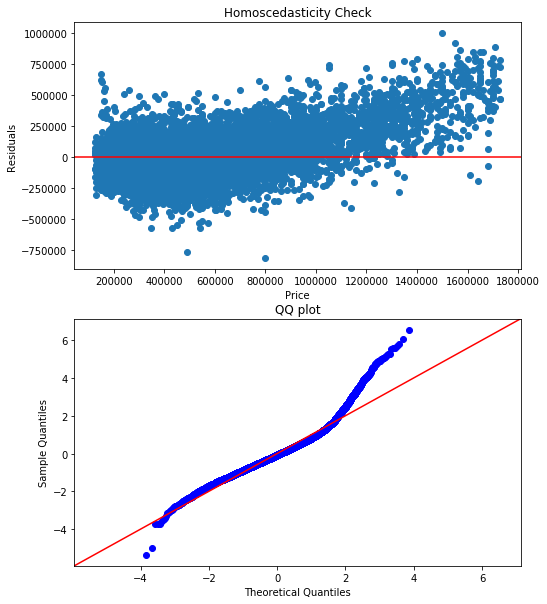

In [34]:
ModelCheck(X_train, y_train, X_test, y_test)

## Stepwise Selection of features

In [35]:
len(X_train.columns)

11

In [36]:
results = stepwise_selection(X_train,y_train)

/Users/stevenkyle/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


Add  bedrooms                       with p-value 0.0
Add  bathrooms                      with p-value 0.0
Add  sqft_living                    with p-value 0.0
Add  grade                          with p-value 0.0
Add  DistanceFromCenterOfSeattle    with p-value 0.0
Add  view                           with p-value 1.9472e-189
Add  condition                      with p-value 4.42334e-100
Drop                              1 with p-value 0.365183
Add  waterfront_1.0                 with p-value 1.19736e-45
Add  Renovated_1                    with p-value 2.12829e-33
Add  sqft_basement                  with p-value 1.10337e-29
Add  floors                         with p-value 2.76649e-12


In [37]:
len(results)

10

## Third Model using Selected Features

In [38]:
X_train=X_train[results]
X_test=X_test[results]

{'Lagrange multiplier statistic': 1180.124154788082, 'p-value': 2.79012991000103e-247, 'f-value': 126.76200339208074, 'f p-value': 1.8143165586469114e-256}
Train Mean Squarred Error: 23156788221.15619
Test Mean Squarred Error: 21778903157.6921
Train Mean Error: 152173.5463908106
Test Mean Error: 147576.7703864402
Difference in Mean Error: -4596.776004370389


/Users/stevenkyle/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.678
Model:                            OLS   Adj. R-squared:                  0.678
Method:                 Least Squares   F-statistic:                     3570.
Date:                Sat, 31 Oct 2020   Prob (F-statistic):               0.00
Time:                        17:28:40   Log-Likelihood:            -2.2630e+05
No. Observations:               16949   AIC:                         4.526e+05
Df Residuals:                   16938   BIC:                         4.527e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                       -3.597e+05   1.37e+04    -26.177      0.000   -3.87e+05   -3.33e+05
bedrooms                    -1.944e+04   1667.493    -11.660      0.000   -2.27e+04   -1.62e+04
sqft_living                   166.0690      2.813     59.041      0.000     160.556     171.582
grade                        8.477e+04   1710.913     49.549      0.000    8.14e+04    8.81e+04
DistanceFromCenterOfSeattle -1.325e+04    176.549    -75.053      0.000   -1.36e+04   -1.29e+04
view                         4.344e+04   1813.779     23.948      0.000    3.99e+04     4.7e+04
condition                    4.291e+04   1896.216     22.628      0.000    3.92e+04    4.66e+04
waterfront_1.0               2.653e+05   1.97e+04     13.452      0.000    2.27e+05    3.04e+05
Renovated_1                  8.012e+04   6546.066     12.240      0.000    6.73e+04     9.3e+04
sqft_basement                 -48.9493      3.701    -13.226      0.000     -56.203     -41.695
floors                      -1.932e+04   2762.403     -6.994      0.000   -2.47e+04   -1.39e+04
==============================================================================
Omnibus:                     3011.467   Durbin-Watson:                   1.992
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             8912.362
Skew:                           0.932   Prob(JB):                         0.00
Kurtosis:                       6.024   Cond. No.                     3.77e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.77e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

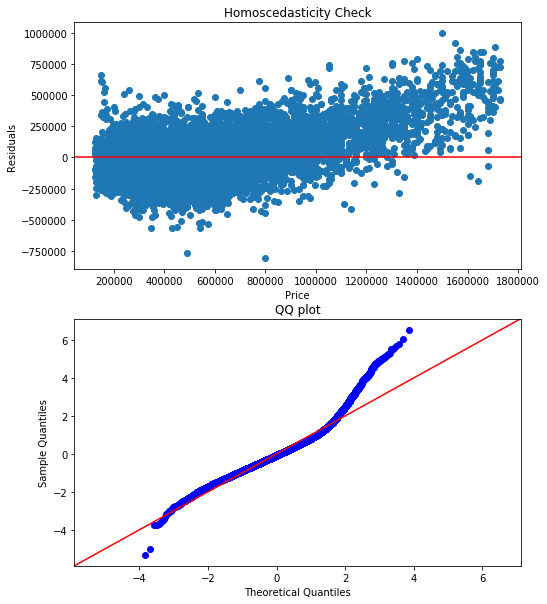

In [39]:
ModelCheck(X_train, y_train, X_test, y_test)

## Scaling features

In [40]:
df_linear.columns

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'floors', 'waterfront',
       'view', 'condition', 'grade', 'sqft_basement', 'Renovated',
       'DistanceFromCenterOfSeattle'],
      dtype='object')

In [41]:
continuous_features = ['bathrooms','sqft_basement',
                       'bedrooms','condition','sqft_living',
                       'DistanceFromCenterOfSeattle']
len(continuous_features)

6

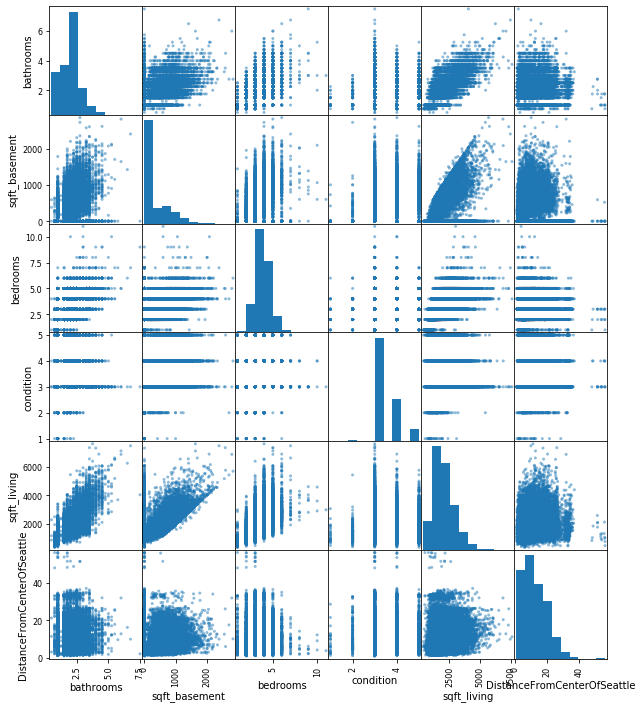

In [42]:
pd.plotting.scatter_matrix(df_linear[continuous_features], figsize=(10,12));

In [43]:
Log_transform=['sqft_living','DistanceFromCenterOfSeattle']
for feature in Log_transform:
    X_train[feature] = X_train[feature].map(lambda x: np.log(x))
    X_test[feature] = X_test[feature].map(lambda x: np.log(x))

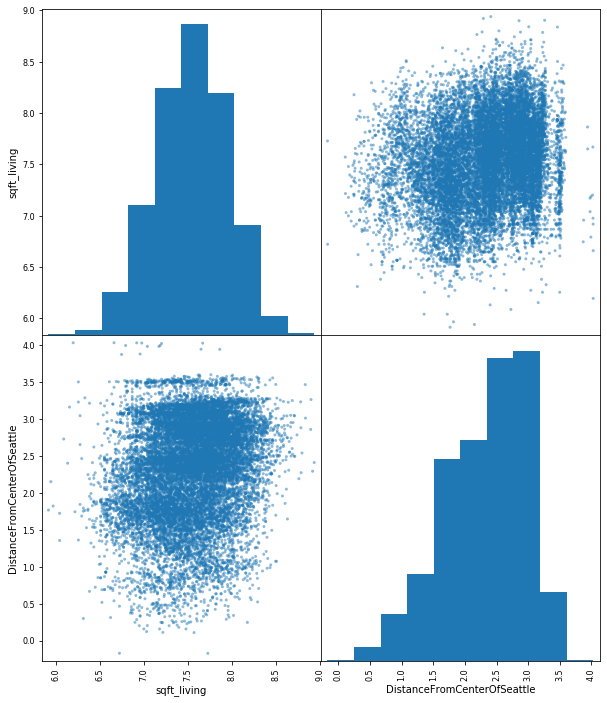

In [44]:
pd.plotting.scatter_matrix(X_train[Log_transform], figsize=(10,12));

## Fourth Model using scaled features

{'Lagrange multiplier statistic': 1228.6701048535106, 'p-value': 9.417138713523459e-258, 'f-value': 132.38408083556837, 'f p-value': 9.72687115162727e-268}
Train Mean Squarred Error: 24284545948.957066
Test Mean Squarred Error: 22591298332.385376
Train Mean Error: 155834.99590578832
Test Mean Error: 150304.01968139567
Difference in Mean Error: -5530.9762243926525


/Users/stevenkyle/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.663
Model:                            OLS   Adj. R-squared:                  0.662
Method:                 Least Squares   F-statistic:                     3326.
Date:                Sat, 31 Oct 2020   Prob (F-statistic):               0.00
Time:                        17:28:56   Log-Likelihood:            -2.2670e+05
No. Observations:               16949   AIC:                         4.534e+05
Df Residuals:                   16938   BIC:                         4.535e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                        -2.15e+06   3.36e+04    -63.954      0.000   -2.22e+06   -2.08e+06
bedrooms                    -1.284e+04   1775.574     -7.230      0.000   -1.63e+04   -9356.779
sqft_living                  2.894e+05   6101.874     47.435      0.000    2.77e+05    3.01e+05
grade                        1.031e+05   1712.213     60.227      0.000    9.98e+04    1.06e+05
DistanceFromCenterOfSeattle -1.504e+05   2022.470    -74.374      0.000   -1.54e+05   -1.46e+05
view                         4.459e+04   1855.738     24.028      0.000     4.1e+04    4.82e+04
condition                    4.067e+04   1942.803     20.933      0.000    3.69e+04    4.45e+04
waterfront_1.0               2.901e+05   2.02e+04     14.355      0.000    2.51e+05     3.3e+05
Renovated_1                   7.23e+04   6715.594     10.766      0.000    5.91e+04    8.55e+04
sqft_basement                 -42.7710      3.859    -11.084      0.000     -50.335     -35.207
floors                      -3.522e+04   2903.971    -12.128      0.000   -4.09e+04   -2.95e+04
==============================================================================
Omnibus:                     2991.146   Durbin-Watson:                   1.984
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             8293.441
Skew:                           0.947   Prob(JB):                         0.00
Kurtosis:                       5.855   Cond. No.                     1.44e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.44e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

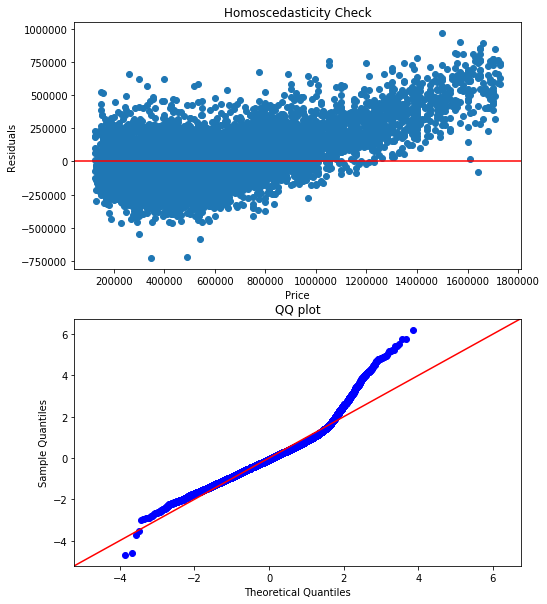

In [45]:
ModelCheck(X_train, y_train, X_test, y_test)

## Fifth Model, dropping features

In [46]:
#dropping bedrooms
#seems weird that increasing in number has a negative correlation
X_train = X_train.drop(['bedrooms'],axis=1)
X_test = X_test.drop(['bedrooms'],axis=1)

{'Lagrange multiplier statistic': 1217.1944927762763, 'p-value': 2.3528029106987582e-256, 'f-value': 145.6218917902048, 'f p-value': 3.64454178364203e-266}
Train Mean Squarred Error: 24359487608.2389
Test Mean Squarred Error: 22597419196.360203
Train Mean Error: 156075.26264030088
Test Mean Error: 150324.37991343986
Difference in Mean Error: -5750.882726861018


/Users/stevenkyle/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.662
Model:                            OLS   Adj. R-squared:                  0.661
Method:                 Least Squares   F-statistic:                     3678.
Date:                Sat, 31 Oct 2020   Prob (F-statistic):               0.00
Time:                        17:28:57   Log-Likelihood:            -2.2673e+05
No. Observations:               16949   AIC:                         4.535e+05
Df Residuals:                   16939   BIC:                         4.536e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                       -2.039e+06      3e+04    -68.050      0.000    -2.1e+06   -1.98e+06
sqft_living                  2.669e+05   5252.085     50.816      0.000    2.57e+05    2.77e+05
grade                        1.053e+05   1687.786     62.396      0.000    1.02e+05    1.09e+05
DistanceFromCenterOfSeattle -1.502e+05   2025.214    -74.146      0.000   -1.54e+05   -1.46e+05
view                         4.547e+04   1854.496     24.521      0.000    4.18e+04    4.91e+04
condition                    4.016e+04   1944.479     20.655      0.000    3.64e+04     4.4e+04
waterfront_1.0               2.934e+05   2.02e+04     14.498      0.000    2.54e+05    3.33e+05
Renovated_1                  7.302e+04   6725.004     10.859      0.000    5.98e+04    8.62e+04
sqft_basement                 -42.8496      3.865    -11.087      0.000     -50.425     -35.274
floors                      -3.498e+04   2908.178    -12.029      0.000   -4.07e+04   -2.93e+04
==============================================================================
Omnibus:                     2974.677   Durbin-Watson:                   1.984
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             8208.494
Skew:                           0.944   Prob(JB):                         0.00
Kurtosis:                       5.839   Cond. No.                     1.28e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.28e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

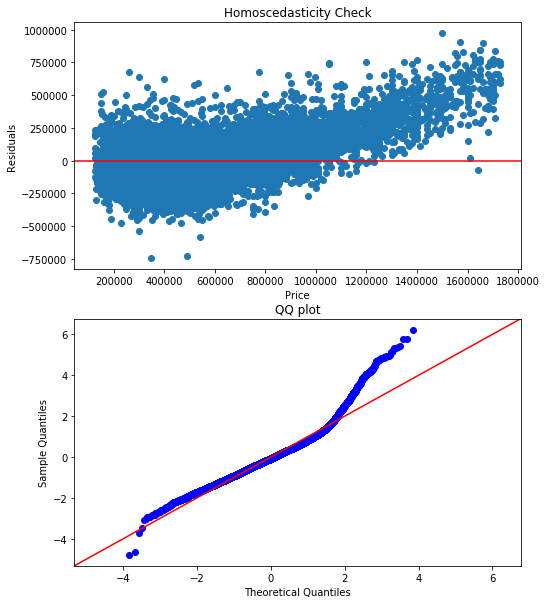

In [47]:
ModelCheck(X_train, y_train, X_test, y_test)

## Sixth Model using scaled dependent value

In [48]:
y_log_train = y_train.apply(lambda x: np.log(x))
y_log_test = y_test.apply(lambda x: np.log(x))

{'Lagrange multiplier statistic': 467.09077465610534, 'p-value': 6.349091398824882e-95, 'f-value': 53.33828289297659, 'f p-value': 2.747285658782546e-96}
Train Mean Squarred Error: 21485632109.63667
Test Mean Squarred Error: 20318239676.62993
Train Mean Error: 146579.78069855567
Test Mean Error: 142542.0628328001
Difference in Mean Error: -4037.717865755578


/Users/stevenkyle/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.676
Model:                            OLS   Adj. R-squared:                  0.675
Method:                 Least Squares   F-statistic:                     3921.
Date:                Sat, 31 Oct 2020   Prob (F-statistic):               0.00
Time:                        17:28:57   Log-Likelihood:                -2168.1
No. Observations:               16949   AIC:                             4356.
Df Residuals:                   16939   BIC:                             4434.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                           8.0574      0.053    152.632      0.000       7.954       8.161
sqft_living                     0.5624      0.009     60.771      0.000       0.544       0.580
grade                           0.1677      0.003     56.377      0.000       0.162       0.173
DistanceFromCenterOfSeattle    -0.2991      0.004    -83.821      0.000      -0.306      -0.292
view                            0.0565      0.003     17.282      0.000       0.050       0.063
condition                       0.0679      0.003     19.818      0.000       0.061       0.075
waterfront_1.0                  0.4140      0.036     11.611      0.000       0.344       0.484
Renovated_1                     0.1015      0.012      8.566      0.000       0.078       0.125
sqft_basement               -9.395e-05   6.81e-06    -13.797      0.000      -0.000   -8.06e-05
floors                         -0.0492      0.005     -9.597      0.000      -0.059      -0.039
==============================================================================
Omnibus:                       62.458   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               83.062
Skew:                          -0.030   Prob(JB):                     9.19e-19
Kurtosis:                       3.338   Cond. No.                     1.28e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.28e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

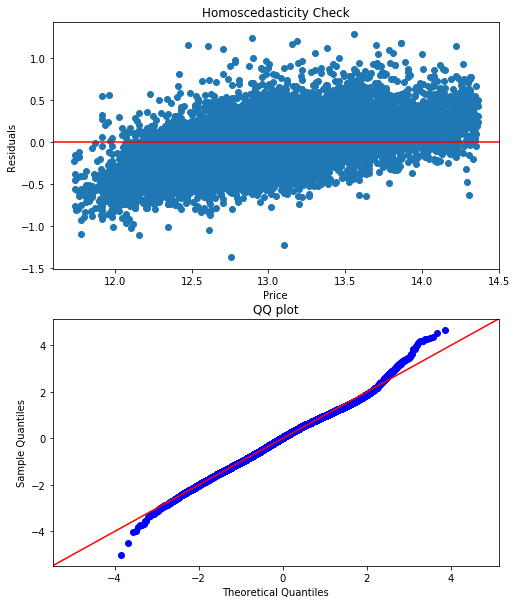

In [49]:
LoggedModelCheck(X_train,y_log_train,X_test,y_log_test)

## Setting up zipcodes for seventh model

In [50]:
testdrop = ['sqft_lot','yr_built','yr_renovated','sqft_lot15',
            'Age_When_Sold','Age_Since_Renovation','Renovated*Age',
            'sqft_living15','sqft_above']

df_test_zip = df.drop(testdrop,axis=1)

Log_transform=['sqft_living','DistanceFromCenterOfSeattle']

for feature in Log_transform:
    df_test_zip[feature] = df_test_zip[feature].map(lambda x: np.log(x))



In [51]:
#Creating Dummie Variables double check this list
#Taking out bedrooms, bathrooms, view, condition
dummy_list_zip = ['Renovated','waterfront','zipcode'] #Trying grade as a continuous variable, Also try without zipcode
dum=df_test_zip[dummy_list_zip].astype('category')
dummies = pd.get_dummies(dum[dummy_list_zip],prefix=dummy_list_zip,drop_first=True)
df_preprocessed = df_test_zip.drop(dummy_list_zip, axis=1)
df_preprocessed = pd.concat([df_preprocessed,dummies],axis=1)

In [52]:
y_zipcode = df_preprocessed['price']
X_zipcode = df_preprocessed.drop(['price'],axis=1)

X_zipcode_train, X_zipcode_test, y_zipcode_train, y_zipcode_test = train_test_split(X_zipcode, y_zipcode, test_size=0.2)


In [53]:
results_zip = stepwise_selection(X_zipcode_train,y_zipcode_train)

/Users/stevenkyle/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


Add  bathrooms                      with p-value 0.0
Add  sqft_living                    with p-value 0.0
Add  DistanceFromCenterOfSeattle    with p-value 0.0
Add  grade                          with p-value 0.0
Add  zipcode_98004                  with p-value 1.86576e-258
Add  view                           with p-value 2.95098e-246
Drop                              0 with p-value 0.0659194
Add  zipcode_98040                  with p-value 3.04168e-119
Add  zipcode_98033                  with p-value 3.80495e-90
Add  condition                      with p-value 1.24419e-87
Add  zipcode_98053                  with p-value 1.64156e-67
Add  zipcode_98039                  with p-value 6.85952e-64
Add  zipcode_98105                  with p-value 1.82229e-55
Add  zipcode_98112                  with p-value 3.18139e-58
Add  zipcode_98023                  with p-value 3.37111e-58
Add  zipcode_98115                  with p-value 7.42936e-57
Add  zipcode_98117                  with p-value 2.2909

In [54]:
X_zipcode_train=X_zipcode_train[results_zip]
X_zipcode_test=X_zipcode_test[results_zip]

In [55]:
y_log_zip_train = y_zipcode_train.apply(lambda x: np.log(x))
y_log_zip_test = y_zipcode_test.apply(lambda x: np.log(x))

## Seventh Model, using zipcodes

{'Lagrange multiplier statistic': 905.512915911588, 'p-value': 3.471018568124558e-147, 'f-value': 14.220643446121464, 'f p-value': 7.4699201864583516e-152}
Train Mean Squarred Error: 10240982770.303257
Test Mean Squarred Error: 10950177992.657246
Train Mean Error: 101197.74093478202
Test Mean Error: 104643.09816063955
Difference in Mean Error: 3445.3572258575296


/Users/stevenkyle/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.861
Model:                            OLS   Adj. R-squared:                  0.861
Method:                 Least Squares   F-statistic:                     1567.
Date:                Sat, 31 Oct 2020   Prob (F-statistic):               0.00
Time:                        17:30:55   Log-Likelihood:                 5076.2
No. Observations:               16949   AIC:                        -1.002e+04
Df Residuals:                   16881   BIC:                            -9490.
Df Model:                          67                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                           8.0823      0.046    174.702      0.000       7.992       8.173
sqft_living                     0.5538      0.008     73.514      0.000       0.539       0.569
DistanceFromCenterOfSeattle    -0.1749      0.006    -27.258      0.000      -0.187      -0.162
grade                           0.1012      0.002     47.911      0.000       0.097       0.105
zipcode_98004                   0.9124      0.014     65.116      0.000       0.885       0.940
view                            0.0709      0.002     32.128      0.000       0.067       0.075
zipcode_98040                   0.6836      0.014     47.624      0.000       0.655       0.712
zipcode_98033                   0.6222      0.011     57.081      0.000       0.601       0.644
condition                       0.0530      0.002     23.013      0.000       0.049       0.058
zipcode_98053                   0.5596      0.011     51.517      0.000       0.538       0.581
zipcode_98039                   1.0648      0.044     24.090      0.000       0.978       1.151
zipcode_98105                   0.6761      0.016     42.819      0.000       0.645       0.707
zipcode_98112                   0.6314      0.018     35.449      0.000       0.596       0.666
zipcode_98023                  -0.0498      0.010     -5.022      0.000      -0.069      -0.030
zipcode_98115                   0.5811      0.011     53.891      0.000       0.560       0.602
zipcode_98117                   0.5734      0.011     53.616      0.000       0.552       0.594
waterfront_1.0                  0.3937      0.023     16.873      0.000       0.348       0.439
zipcode_98006                   0.5157      0.010     49.832      0.000       0.495       0.536
zipcode_98052                   0.5318      0.009     57.534      0.000       0.514       0.550
zipcode_98075                   0.5415      0.011     47.427      0.000       0.519       0.564
zipcode_98199                   0.5656      0.014     39.877      0.000       0.538       0.593
zipcode_98103                   0.5371      0.012     46.548      0.000       0.514       0.560
zipcode_98005                   0.5919      0.016     36.416      0.000       0.560       0.624
zipcode_98074                   0.5116      0.010     49.521      0.000       0.491       0.532
zipcode_98029                   0.5527      0.012     46.074      0.000       0.529       0.576
zipcode_98027                   0.4869      0.010     46.609      0.000       0.466       0.507
zipcode_98008                   0.5253      0.013     41.660      0.000       0.501       0.550
zipcode_98119                   0.5873      0.019     31.711      0.000       0.551       0.624
zipcode_98065                   0.4429      0.013     35.185      0.000       0.418       0.468
zipcode_980

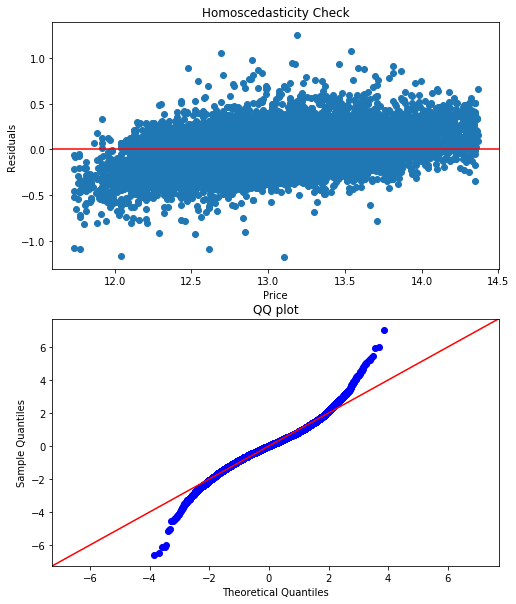

In [56]:
LoggedModelCheck(X_zipcode_train, y_log_zip_train, X_zipcode_test,y_log_zip_test)

# Json

In [58]:
import json

In [59]:
f = open('School_Districts_in_King_County___schdst_area.geojson')
schooldata = json.load(f)
print(type(schooldata))

<class 'dict'>


In [60]:
schooldata.keys()

dict_keys(['type', 'name', 'crs', 'features'])

In [61]:
for v in schooldata.values():
    print(type(v))

<class 'str'>
<class 'str'>
<class 'dict'>
<class 'list'>


In [109]:
schooldatafeatures = schooldata['features']

In [115]:
districtnames=[]
for district in schooldatafeatures:
    districtnames.append(district['properties']['NAME'])

In [116]:
districtnames

['Seattle',
 'Federal Way',
 'Enumclaw',
 'Mercer Island',
 'Highline',
 'Vashon Island',
 'Renton',
 'Skykomish',
 'Bellevue',
 'Tukwila',
 'Riverview',
 'Auburn',
 'Tahoma',
 'Snoqualmie Valley',
 'Issaquah',
 'Shoreline',
 'Lake Washington',
 'Kent',
 'Northshore',
 'Fife']

In [94]:
coordinates = schooldata['features'][0]['geometry']['coordinates']

In [102]:
len(coordinates[0][0])

3838

In [103]:
len(coordinates[1][0])

2169

In [138]:
schoollat=[]
schoollong=[]
for entries in coordinates:
    for nextentry in entries:
        for nextnextentry in nextentry:
            schoollat.append(nextnextentry[0])
            schoollong.append(nextnextentry[1])

In [121]:
np.min(schoollat)

-122.44124758244769

In [122]:
np.max(schoollat)

-122.23600658023713

In [123]:
np.min(schoollong)

47.49523293330664

In [124]:
np.max(schoollong)

47.73416642533758

In [125]:
schooldistrictdf = pd.DataFrame()

In [127]:
schooldistrictdf['Districts'] = districtnames

In [128]:
schooldistrictdf

,Districts
0,Seattle
1,Federal Way
2,Enumclaw
3,Mercer Island
4,Highline
5,Vashon Island
6,Renton
7,Skykomish
8,Bellevue
9,Tukwila


In [196]:
DistrictMinLat = []
DistrictMaxLat = []
DistrictMinLong = []
DistrictMaxLong = []

for i in list(range(len(schooldatafeatures))):
    schoollat=[]
    schoollong=[]
    if len(schooldatafeatures[i]['geometry']['coordinates']) == 2 :
        for entries in schooldatafeatures[i]['geometry']['coordinates']:
            for nextentry in entries:
                for nextnextentry in nextentry:
                    districtlat = (nextnextentry[0])
                    districtlong = (nextnextentry[1])
                    schoollat.append(districtlat)
                    schoollong.append(districtlong)
    if len(schooldatafeatures[i]['geometry']['coordinates']) == 1:
        for entries in schooldatafeatures[i]['geometry']['coordinates']:
            for nextentry in entries:
                districtlat=(nextentry[0])
                districtlong=(nextentry[1])
                schoollat.append(districtlat)
                schoollong.append(districtlong)
    DistrictMinLat.append(np.min(schoollat))
    DistrictMaxLat.append(np.max(schoollat))
    DistrictMinLong.append(np.min(schoollong))
    DistrictMaxLong.append(np.max(schoollong))

In [198]:
DistrictMinLong

[47.49523293330664,
 47.25726486525117,
 47.08486429155255,
 47.52443922428892,
 47.37575900866263,
 47.33063929550873,
 47.429858017221896,
 47.51206069882483,
 47.53772626559033,
 47.445023266738716,
 47.583428207762225,
 47.22824190825748,
 47.313373652201456,
 47.33929024250949,
 47.42914252079446,
 47.733741997151604,
 47.601365153201414,
 47.30124592536611,
 47.71115073019409,
 47.25720535555588]

In [199]:
schooldistrictdf['DistrictMinLat'] = DistrictMinLat
schooldistrictdf['DistrictMaxLat'] = DistrictMaxLat
schooldistrictdf['DistrictMinLong'] = DistrictMinLong
schooldistrictdf['DistrictMaxLong'] = DistrictMaxLong

In [200]:
schooldistrictdf

,Districts,DistrictMinLat,DistrictMaxLat,DistrictMinLong,DistrictMaxLong
0,Seattle,-122.441248,-122.236007,47.495233,47.734166
1,Federal Way,-122.417716,-122.249792,47.257265,47.393900
2,Enumclaw,-122.117719,-121.297778,47.084864,47.387173
3,Mercer Island,-122.254506,-122.201586,47.524439,47.596037
4,Highline,-122.382935,-122.264172,47.375759,47.517426
5,Vashon Island,-122.528504,-122.373769,47.330639,47.511185
6,Renton,-122.272747,-122.111996,47.429858,47.549428
7,Skykomish,-121.598509,-121.064280,47.512061,47.780576
8,Bellevue,-122.243221,-122.086939,47.537726,47.653461
9,Tukwila,-122.297609,-122.242633,47.445023,47.510177
